In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from enum import Enum

In [2]:
class Colors(Enum):
    blue = '#0A85FF'
    darkblue = '#00264D'
    green = '#99CC00'
    darkgreen = '#739900'

In [3]:
battleground_path = 'battleground-state-changes.csv'
df = pd.read_csv(battleground_path)

# Data Exploration and Formatting

In [5]:
df.head(2)

,state,timestamp,leading_candidate_name,trailing_candidate_name,leading_candidate_votes,trailing_candidate_votes,vote_differential,votes_remaining,new_votes,new_votes_relevant,new_votes_formatted,leading_candidate_partition,trailing_candidate_partition,precincts_reporting,precincts_total,hurdle,hurdle_change,hurdle_mov_avg,counties_partition,total_votes_count
0,Alaska (EV: 3),2020-11-19 13:18:50.262000,Trump,Biden,189457,153551,35906,9210,7323,6977,"6,977",0.528594,0.471406,407,441,2.527651,0.910664,0.489933,"{'ED 1': 164, 'ED 10': 312, 'ED 11': 174, 'ED ...",356796
1,Alaska (EV: 3),2020-11-18 17:25:33.757000,Trump,Biden,185769,150262,35507,16533,0,0,0,0.000000,0.000000,389,441,1.616987,0.000000,0.514500,{},349473


In [6]:
# Restructure data frame for easier access to Biden and Trump votes

def get_candidate_votes(row):
    if row['leading_candidate_name'] == 'Biden':
        row['biden_votes'] = row['leading_candidate_votes']
        row['trump_votes'] = row['trailing_candidate_votes']
    elif row['leading_candidate_name'] == 'Trump':
        row['biden_votes'] = row['trailing_candidate_votes']
        row['trump_votes'] = row['leading_candidate_votes']
    return row

df = df.apply(get_candidate_votes, axis=1)

In [7]:
df.head(2)

,state,timestamp,leading_candidate_name,trailing_candidate_name,leading_candidate_votes,trailing_candidate_votes,vote_differential,votes_remaining,new_votes,new_votes_relevant,...,trailing_candidate_partition,precincts_reporting,precincts_total,hurdle,hurdle_change,hurdle_mov_avg,counties_partition,total_votes_count,biden_votes,trump_votes
0,Alaska (EV: 3),2020-11-19 13:18:50.262000,Trump,Biden,189457,153551,35906,9210,7323,6977,...,0.471406,407,441,2.527651,0.910664,0.489933,"{'ED 1': 164, 'ED 10': 312, 'ED 11': 174, 'ED ...",356796,153551,189457
1,Alaska (EV: 3),2020-11-18 17:25:33.757000,Trump,Biden,185769,150262,35507,16533,0,0,...,0.000000,389,441,1.616987,0.000000,0.514500,{},349473,150262,185769


In [8]:
df["state"].unique()

array(['Alaska (EV: 3)', 'Arizona (EV: 11)', 'Georgia (EV: 16)',
       'North Carolina (EV: 15)', 'Nevada (EV: 6)',
       'Pennsylvania (EV: 20)'], dtype=object)

In [9]:
df.shape

(730, 22)

In [33]:
class LinearRegression():
  def __init__(self):
    # no hyperparameters for linear regression
    self.w = None
    self.b = None

  def fit(self, X, y):
    # computes the Linear Regression model parameters
    X_hat = np.concatenate((X, np.ones((X.shape[0],1))),axis=1)
    #compute SVD
    U, S, V = np.linalg.svd(X_hat, full_matrices=False)
    #compute S_plus from S
    idx = np.where(S > 1e-10)
    S_plus = np.zeros(S.shape)
    S_plus[idx] = 1 / S[idx]
    S_plus = np.diag(S_plus)
    #conjugate and transpose V and U and build A_hat_plus
    X_hat_plus = (V.conj().T).dot(S_plus).dot(U.conj().T)
    #compute the w/b result
    w_hat = np.dot(X_hat_plus, y)
    self.w = w_hat[:-1]
    self.b = w_hat[-1]
  
  def predict(self, x):
    """ 
    Define the line here.
    Map x to it's y coordinates. The set {(x,y) | x from input, y from output} 
    should define your line.
    In this case x will be percentages reported like
    np.linspace(0.94, 1, 100).reshape([-1,1]) from 94% to 100%
    in Georgia
    """
    if self.w and self.b:
        #wnorm = np.linalg.norm(self.w)
        #we = w / wnorm
        #y = np.dot(x, we) + self.b
        y = np.dot(x, self.w) + self.b
    else:
        raise Exception("No data fit to this Linear Regression Object! Call the 'fit' function first!")
    return y

# Fit Pennsylvania

In [30]:
#Pennsylvania
df_py = df[df['state'] == 'Pennsylvania (EV: 20)'].copy()
df_py['percent_reporting'] = df_py['total_votes_count'] / int(7e+6)
df_py['trump_lead'] = (df_py['trump_votes'] - df_py['biden_votes']) / df_py['total_votes_count']
df_py = df_py.sort_values('percent_reporting', axis=0, ascending=False)

# Only view votes that were counted before 90% were reported
df_py = df_py[df_py['percent_reporting'] <= 0.9]

In [31]:
df_py[["percent_reporting","trump_lead"]].head()

,percent_reporting,trump_lead
660,0.899778,0.029651
661,0.898325,0.030371
662,0.898141,0.030600
663,0.898078,0.030602
664,0.896734,0.031217


In [39]:
X = df_py['percent_reporting'].to_numpy().reshape([-1, 1])
y = df_py['trump_lead'].to_numpy()

# Fit X to y using Linear Regression
linear_py = LinearRegression()
linear_py.fit(X, y)

# Fit Georgia

In [35]:
#Georgia
df_ga = df[df['state'] == 'Georgia (EV: 16)'].copy()
df_ga['percent_reporting'] = df_ga['total_votes_count'] / int(5.025e+6)
df_ga['trump_lead'] = (df_ga['trump_votes'] - df_ga['biden_votes']) / df_ga['total_votes_count']
df_ga = df_ga.sort_values('percent_reporting', axis=0, ascending=False)

# Only view votes that were counted before 97% were reported
df_ga = df_ga[df_ga['percent_reporting'] <= 0.97]

In [36]:
df_ga[["percent_reporting","trump_lead"]].head()

,percent_reporting,trump_lead
283,0.969762,0.007659
289,0.967424,0.009461
290,0.967372,0.009451
291,0.967222,0.009483
292,0.966666,0.009846


In [40]:
X = df_ga['percent_reporting'].to_numpy().reshape([-1, 1])
y = df_ga['trump_lead'].to_numpy()

# Fit X to y using Linear Regression
linear_ga = LinearRegression()
linear_ga.fit(X, y)

# Plot the linear regessions of 'percent reporting' vs 'Trump's percent lead'

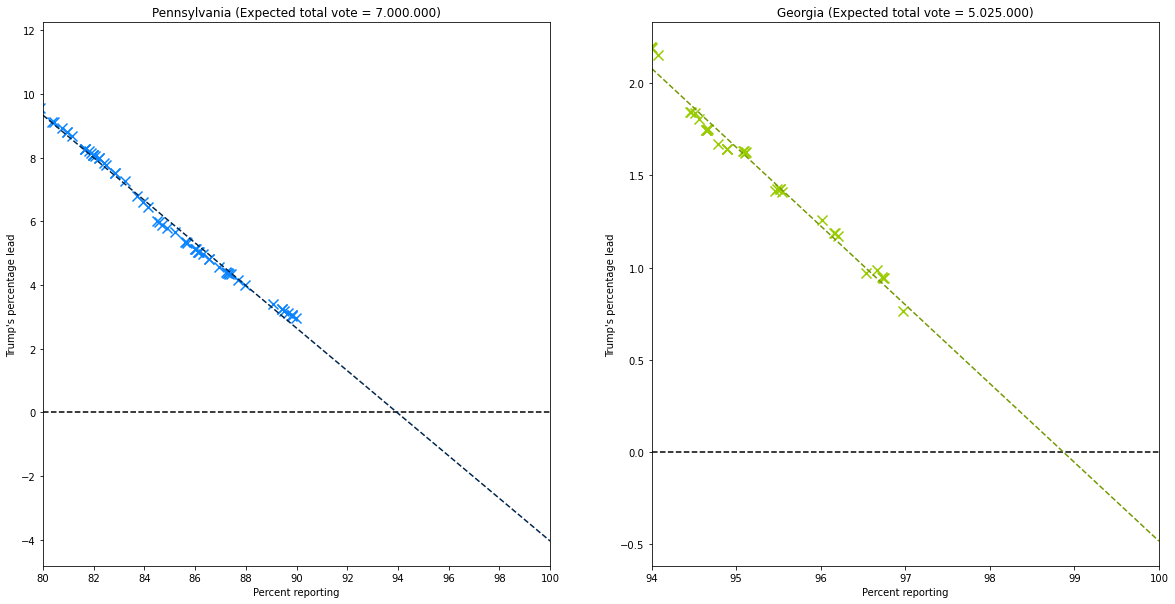

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].scatter(df_py['percent_reporting'] * 100, df_py['trump_lead'] * 100, marker='x', s=100, color=Colors.blue.value)
x_py = np.linspace(0.8, 1, 100).reshape([-1,1])
y_py = linear_py.predict(x_py)
ax[0].set_xlim([85, 100])
ax[0].set_xticks(range(80, 101, 2))
ax[0].plot(x_py * 100, y_py * 100, linestyle='--', color=Colors.darkblue.value)
ax[0].hlines(y=0, xmin=80, xmax=100, linestyle='--', color='black')
ax[0].set_title('Pennsylvania (Expected total vote = 7.000.000)')

ax[1].scatter(df_ga['percent_reporting'] * 100, df_ga['trump_lead'] * 100, marker='x', s=100, color=Colors.green.value)
x_ga = np.linspace(0.94, 1, 100).reshape([-1,1])
y_ga = linear_ga.predict(x_ga)
ax[1].set_xlim([94, 100])
ax[1].set_xticks(range(94, 101, 1))
ax[1].plot(x_ga * 100, y_ga * 100, linestyle='--', color=Colors.darkgreen.value)
ax[1].hlines(y=0, xmin=94, xmax=100, linestyle='--', color='black')
ax[1].set_title('Georgia (Expected total vote = 5.025.000)')
#x and y abels were swapped from the kvv version, it was wrong before
ax[0].set_xlabel("Percent reporting")
ax[0].set_ylabel("Trump's percentage lead")
ax[1].set_xlabel("Percent reporting")
ax[1].set_ylabel("Trump's percentage lead")
plt.show()
# plt.savefig('trump_lead.svg', transparent=True)

# Q: At what percentage of reported votes will Biden lead over Trump?

## Pennsylvania

In [66]:
print("Biden will lead after {:.4f}% of the votes are counted".format(x_py[np.where(y_py<0)][0][0]))

Biden will lead after 0.9414% of the votes are counted


## Georgia

In [67]:
print("Biden will lead after {:.4f}% of the votes are counted".format(x_ga[np.where(y_ga<0)][0][0]))

Biden will lead after 0.9891% of the votes are counted
